# Environment Setup

In [ ]:
! pip3 install --upgrade google-cloud-aiplatform
! pip3 install gymnasium
! pip3 install torchvision

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Peg Solitaire Game Overview

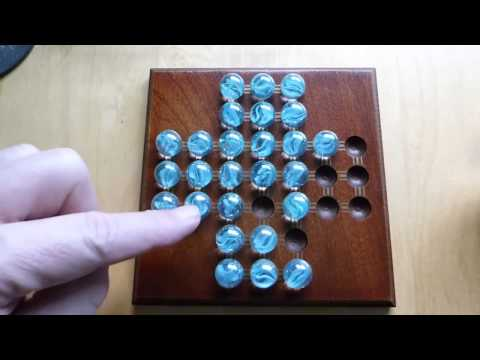

In [ ]:
from IPython.display import YouTubeVideo
vid=YouTubeVideo('qTOhdAHP05s')
display(vid)

# Algorithm design for Peg Solitaire

***

## Observation Space

The state of the game is represented by a **33-element binary vector**, corresponding to the 33 positions on a standard English peg solitaire board. Each element in the vector indicates whether a position is occupied by a peg.

* `1`: The position is occupied.
* `0`: The position is empty.

***

## Action Space

The action space consists of all **76 geometrically possible jumps** on the board. Each action is defined by a tuple: `(from_location, via_location, to_location)`.

At each step, a validation process filters this space to determine the subset of **legal moves**. An action is only considered valid if:
1.  The `from_location` contains a peg.
2.  The `via_location` contains a peg to be jumped over.
3.  The `to_location` is empty.

***

## Reward Function

Peg solitaire uses a **sparse/late reward** structure, where the outcome is unknown until the end of the episode (a single game). The reward mechanism is defined as follows:

* **Intermediate Steps**: The reward for any valid move during the game is **0**.

* **Terminal State**: When an episode ends (i.e., no more valid moves are possible), the final reward is awarded:
    * **Win Condition**: If only one peg remains on the board, a large positive reward of **+100** is given.
    * **Loss Condition**: If multiple pegs remain, a penalty is calculated. The reward is the **negative sum of the Manhattan distances** of each remaining peg from the center of the board. This penalizes solutions that leave pegs scattered far from the center.
      * *Penalty Formula*: Reward = -sum(|row_p - row_c| + |col_p - col_c|) for all remaining pegs.
        * Where $(row_p,col_p)$ is the coordinates of each individual remaining pegs and $(row_c, col_c)$ are the coordinates of the board's center.

# Download the custom Environment for Peg Solitaire and switch working direcotry

In [ ]:
%cd /content
%rm -rf PegSolitaire
!git clone https://github.com/DigitalWNZ/PegSolitaire.git
%cd PegSolitaire

/content
Cloning into 'PegSolitaire'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 18 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 13.78 KiB | 3.44 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/PegSolitaire


# Test the custom environment

In [ ]:
import gymnasium as gym
from PegSolitaire_Env.envs import obs_to_board

env = gym.make('pegsolitaire-v0',render_mode='human', reward_range=(-100,100))

print(f"env.observation_space: {env.observation_space}")
print(f"env.action_space: {env.action_space}")
print(f"env.spec.max_episode_steps: {env.spec.max_episode_steps}")
print(f"env.metadata: {env.metadata}")
print(f"env.reward_range: {env.unwrapped.reward_range}")

obs,info = env.reset()
print(f"initial obs: {obs}")
print(f"valid actions: {obs_to_board(obs).valid_actions()}")

solution_actions = [
    68, 49, 71, 33, 75, 71, 5, 11,
    20, 46, 11, 27, 3, 40, 1, 3,
    69, 65, 57, 28, 65, 20, 12, 49,
    57, 62, 27, 39, 7, 35, 44
]

for action in solution_actions:
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"obs: {obs}; reward: {reward}; terminated: {terminated};truncated: {truncated}; info: {info}")
    print(f"valid actions: {obs_to_board(obs).valid_actions()}")

env.observation_space: Box(0.0, 1.0, (33,), float32)
env.action_space: Discrete(76)
env.spec.max_episode_steps: 31
env.metadata: {'render_modes': ['human']}
env.reward_range: (-90, 90)
initial obs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
valid actions: [7, 31, 44, 68]
obs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1.]; reward: 0; terminated: False;truncated: False; info: {}
valid actions: [19, 49, 63]
obs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1.]; reward: 0; terminated: False;truncated: False; info: {}
valid actions: [12, 15, 37, 60, 71]
obs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1.]; reward: 0; terminated: False;truncated: False; info: {}
valid actions: [12, 33, 37, 56, 75]
obs: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment pegsolitaire-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# Run the training process following A2C algorithms

**A2C (Advantage Actor-Critic)** algorithm mechanism in reinforcement learning.

A2C is a powerful and efficient reinforcement learning algorithm that cleverly combines the advantages of two mainstream approaches: **Policy-Based** and **Value-Based** methods. To understand A2C, we can think of it as a learning team composed of two parts: the **Actor** and the **Critic**.

- **Actor**: Responsible for decision-making. It's a policy network that decides which action `a` to take based on the current environment state `s`. Its goal is to learn an optimal policy to achieve maximum long-term rewards.
- **Critic**: Responsible for evaluation. It's a value network that evaluates how good the actions chosen by the actor are. It doesn't directly select actions but guides the actor's learning by providing feedback.

This process is like an actor performing on stage while a critic in the audience gives scores and suggestions based on the performance, helping the actor continuously improve their acting skills.

## A2C Workflow

The entire training process is as follows:

1. **Interaction and Data Collection**: The actor interacts with the environment according to the current policy, collecting a series of experience data, typically sequences of `(state, action, reward, next_state)`.

2. **Critic Evaluation**: For each step of collected experience `(s, r, s')`:
   - The critic calculates the value of the current state `V(s)` and the value of the next state `V(s')`.
   - Using these values, it calculates the **TD Target**: `Y = r + γ * V(s')` (where `γ` is the discount factor). This can be seen as a more accurate estimate of `Q(s, a)`.
   - It calculates the **TD Error**, which is used as a good estimate of the advantage function in practice: `Advantage ≈ Y - V(s) = r + γ * V(s') - V(s)`.

3. **Update Critic Network**: The critic's goal is to make its prediction `V(s)` as close as possible to the TD target `Y`. Therefore, it updates its network parameters by minimizing the **Mean Squared Error (MSE)** between them. This makes the critic's evaluation increasingly accurate.

4. **Update Actor Network**: The actor uses the advantage calculated by the critic to update its policy.
   - It updates policy parameters in the direction that makes the **advantage larger**. Specifically, it maximizes `log(π(a|s)) * Advantage` through policy gradient ascent, where `π(a|s)` is the probability of choosing action `a` in state `s`.
   - If the advantage is positive, the actor increases `π(a|s)`; if negative, it decreases it.
   - In current practice, we did not adopt another network but build a **pi** function to find the action which can bring the maximum V(s') based on the latest **Critic Network** (Net function in the code)

5. **Repeat**: The entire process repeats continuously, with the actor and critic co-evolving until the actor learns the optimal policy.

In [ ]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import random

from PegSolitaire_Env.envs import obs_to_board, board_to_obs
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
LR = 0.001
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DECAY_PC = 50
GAMMA = 1
# NUM_EPISODES = 20000
NUM_EPISODES = 2000
PATH = "td_solitaire.pt"


def make_linear_decay_schedule(start_val, end_val, decay_pc):
    range_val = end_val - start_val
    decay_episodes = NUM_EPISODES * decay_pc / 100
    per_episode_delta = range_val / decay_episodes

    def linear_decay_schedule(episode):
        if episode > decay_episodes:
            return end_val
        else:
            return start_val + per_episode_delta * episode

    return linear_decay_schedule


def fst(pair):
    return pair[0]


def snd(pair):
    return pair[1]


class Net(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        layers = [
            nn.Linear(in_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_valid_actions(net, s):
    current_board = obs_to_board(s)

    def evaluate_valid_action(a):
        new_board = current_board.make_move(a)
        s2 = board_to_obs(new_board)
        return s2

    valid_actions = current_board.valid_actions()
    s2s = list(map(evaluate_valid_action, valid_actions))

    with torch.no_grad():
        x = torch.tensor(s2s)
        s2_values = net(x).squeeze(-1).numpy()
        s2_value_a_pairs = list(zip(s2_values, valid_actions))

    return s2_value_a_pairs


def make_policy(net):
    def pi(s, epsilon=0):
        s2_value_a_pairs = evaluate_valid_actions(net, s)
        if random.random() < epsilon:
            return random.choice(s2_value_a_pairs)
        else:
            best_pair = s2_value_a_pairs[0]
            for pair in s2_value_a_pairs[1:]:
                if fst(pair) > fst(best_pair):
                    best_pair = pair
            return best_pair

    return pi


def show_plots(final_rewards, final_rewards_ma):
    mpl.rcParams['toolbar'] = 'None'
    plt.figure(figsize=(6, 8))
    plt.subplot(211)
    plt.plot(final_rewards, linewidth=0.5)
    plt.ylabel('Final Reward')
    plt.xlabel('Episodes')
    plt.subplot(212)
    plt.plot([0] * 100 + final_rewards_ma, linewidth=0.5)
    plt.ylabel('Final Reward (moving average)')
    plt.xlabel('Episodes')
    plt.show()


def train(env, pi, net, loss_fn, opt):
    final_rewards = []
    final_rewards_ma = []
    best_final_reward = -np.inf
    best_final_reward_ma = -np.inf
    epsilon_decay_schedule = make_linear_decay_schedule(EPSILON_START, EPSILON_END, EPSILON_DECAY_PC)
    for episode in range(NUM_EPISODES):
        epsilon = epsilon_decay_schedule(episode)
        s,info = env.reset()
        while True:
            # Use the policy to choose an action. Also, return the current
            # estimate of the value of the next state that the chosen action
            # leads to.
            s2_value, a = pi(s, epsilon)

            # Step the environment using the chosen action returning the next
            # state, the reward, the terminaited/truncated flag and the info dict (which we
            # ignore).
            s2, r, terminiated, truncated, _ = env.step(a)

            # Get the current estimate of the value of the current state.
            s_value = net(torch.tensor(s)).squeeze()

            # Calculate the TD target value of the current state based on the
            # reward received from the environment plus the discounted estimate
            # of the next state. If the terminated/truncated flag is set, use the reward only.
            s_value_target = r + (1 - terminiated) * GAMMA * s2_value

            # Calculate the loss.
            target = torch.tensor(s_value_target, dtype=torch.float32)
            loss = loss_fn(s_value, target)

            # Back propagate the loss.
            opt.zero_grad()
            loss.backward()
            opt.step()

            if terminiated:
                # Update stats.
                final_rewards.append(r)
                if r > best_final_reward:
                    best_final_reward = r
                final_reward_ma = -np.inf
                if len(final_rewards) >= 100:
                    final_reward_ma = np.mean(final_rewards[-100:])
                    final_rewards_ma.append(final_reward_ma)
                    if final_reward_ma > best_final_reward_ma:
                        best_final_reward_ma = final_reward_ma
                print(f"episode: {episode:5}; "
                      f"epsilon: {epsilon:.3f}; "
                      f"final reward (best): {r:3} ({best_final_reward:3}); "
                      f"final reward ma (best): {final_reward_ma:8.3f} ({best_final_reward_ma:8.3f})")

                # If the moving average final reward looks good enough,
                # save the trained model and return.
                if final_reward_ma >= 50:
                    show_plots(final_rewards, final_rewards_ma)
                    print(f"saving trained model to {PATH}")
                    torch.save(net.state_dict(), PATH)
                    return

                break

            s = s2
    show_plots(final_rewards, final_rewards_ma)


def play(env, pi):
    actions = []
    s,info = env.reset()
    while True:
        _, a = pi(s)
        actions.append(a)
        s2, _, terminiated, truncated, _ = env.step(a)
        if terminiated:
            print(f"actions: {actions}")
            env.render()
            break
        s = s2

def play_with_reward(env, pi):
    episode_reward = 0
    actions = []
    s,info = env.reset()
    while True:
        _, a = pi(s)
        actions.append(a)
        s2, reward, terminiated, truncated, _ = env.step(a)
        episode_reward += reward
        if terminiated:
            print(f"actions: {actions}")
            print(f"episode_reward: {episode_reward}")
            env.render()
            break
        s = s2

    return episode_reward

episode:     0; epsilon: 1.000; final reward (best): -15 (-15); final reward ma (best):     -inf (    -inf)
episode:     1; epsilon: 0.999; final reward (best): -21 (-15); final reward ma (best):     -inf (    -inf)
episode:     2; epsilon: 0.998; final reward (best): -19 (-15); final reward ma (best):     -inf (    -inf)
episode:     3; epsilon: 0.997; final reward (best): -24 (-15); final reward ma (best):     -inf (    -inf)
episode:     4; epsilon: 0.996; final reward (best): -29 (-15); final reward ma (best):     -inf (    -inf)
episode:     5; epsilon: 0.995; final reward (best): -26 (-15); final reward ma (best):     -inf (    -inf)
episode:     6; epsilon: 0.994; final reward (best): -26 (-15); final reward ma (best):     -inf (    -inf)
episode:     7; epsilon: 0.993; final reward (best): -21 (-15); final reward ma (best):     -inf (    -inf)
episode:     8; epsilon: 0.992; final reward (best): -30 (-15); final reward ma (best):     -inf (    -inf)
episode:     9; epsilon: 0.9

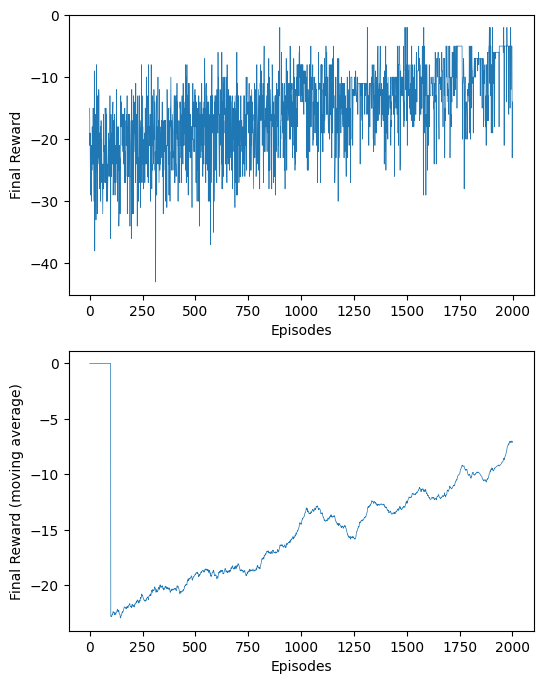

In [ ]:
env = gym.make('pegsolitaire-v0',render_mode='human')
in_dim = env.observation_space.shape[0]
net = Net(in_dim)
pi = make_policy(net)

net.train()
loss_fn = torch.nn.functional.mse_loss
opt = optim.Adam(net.parameters(), lr=LR)
train(env, pi, net, loss_fn, opt)

# Play with the agent

In [ ]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import random

from PegSolitaire_Env.envs import obs_to_board, board_to_obs
import matplotlib as mpl
import matplotlib.pyplot as plt

### Play single time

In [ ]:
env = gym.make('pegsolitaire-v0',render_mode='human')

in_dim = env.observation_space.shape[0]
net = Net(in_dim)
pi = make_policy(net)

net.eval()
net.load_state_dict(torch.load(PATH))
play(env, pi)

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  



/usr/local/lib/python3.12/dist-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


### Play multiple times

In [ ]:

env = gym.make('pegsolitaire-v0',render_mode='human')
in_dim = env.observation_space.shape[0]
net = Net(in_dim)
pi = make_policy(net)

net.eval()
net.load_state_dict(torch.load(PATH))

total_rewards = []
num_episodes = 10

for _ in range(num_episodes):
  episode_reward = play_with_reward(env, pi)
  total_rewards.append(episode_reward)

average_reward = np.mean(total_rewards)

print(f"Test Results over {num_episodes} episodes:")
print(f"Average Reward: {average_reward:.3f}")
print(f"Standard Deviation: {np.std(total_rewards):.3f}")


actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  



/usr/local/lib/python3.12/dist-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...X...
.......
  ...  
  ...  

actions: [44, 69, 65, 28, 57, 65, 73, 41, 74, 8, 17, 27, 0, 32, 66, 47, 33, 71, 58, 4, 0, 56, 30, 15, 49, 11, 20, 54, 24, 13, 7]
episode_reward: 100
  ...  
  ...  
.......
...

# Clean up

In [ ]:
env.close()